In [1]:
cd /Users/festabu/Desktop/ML_galaxy_size_project/Codes/simba/caesar

/Users/festabu/Desktop/ML_galaxy_size_project/Codes/simba/caesar


In [2]:
ls

LICENSE          caesar/          docs/            setup.py
README.rst       caesar.egg-info/ readthedocs.yml  tests/
build/           dist/            scripts/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as norm
import pandas as pd
from matplotlib.gridspec import SubplotSpec
from scipy import stats

import yt
import caesar as caesar

/Users/festabu/opt/anaconda3/envs/festa_env/lib/python3.9/_collections_abc.py:684: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [4]:
#snapnum,snapz=caesar.progen.z_to_snap(redshift=0)
# load in input file
obj = caesar.load('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/simba/m100n1024_151.hdf5')

yt : [INFO     ] 2021-11-11 14:43:21,472 Opening /Users/festabu/Desktop/ML_galaxy_size_project/Codes/simba/m100n1024_151.hdf5
yt : [INFO     ] 2021-11-11 14:43:21,571 Found 464043 halos
yt : [INFO     ] 2021-11-11 14:43:21,597 Found 55609 galaxies


In [5]:
snapnum,snapz=caesar.progen.z_to_snap(redshift=0)

In [6]:
snapnum

151

In [7]:
snapz

0.0

In [8]:
obj.galaxies

In [9]:
len(obj.galaxies)

55609

### Define functions

In [10]:
def read_caesar(caesarfilename):
    '''Function that reads SIMBA files and outputs the fields in a data frame'''
    
    groups=caesar.load(caesarfilename)
    Ngal=len(groups.galaxies)
    idx=np.zeros(Ngal);cent=np.zeros(Ngal);sfr=np.zeros(Ngal);rdisk=np.zeros(Ngal)
    mHI=np.zeros(Ngal);mH2=np.zeros(Ngal);Mstar=np.zeros(Ngal);Mhalo=np.zeros(Ngal); Shalo=np.zeros(Ngal)
    
    for i,galaxy in enumerate(groups.galaxies):
        idx[i] = galaxy.GroupID
        cent[i] = (galaxy.central).astype(int)
        sfr[i] = galaxy.sfr
        rdisk[i]=galaxy.radii['stellar_half_mass']
        Mstar[i] = galaxy.masses['stellar']
        mHI[i] = galaxy.masses['HI']
        mH2[i] = galaxy.masses['H2'] 
        Mhalo[i]=galaxy.halo.masses['total']
        Shalo[i]=galaxy.halo.virial_quantities['spin_param']
    
    df=pd.DataFrame({'GID':idx,'central':cent,'galaxy_mass':Mstar,'galaxy_size':rdisk, 'SFR':sfr,'mHI':mHI,'mH2':mH2,
        'Mhalo':Mhalo, 'Shalo' : Shalo})
    
    return df

In [11]:
def log_mass_size(df):
    '''
    Converts to log10 non-zero size and mass entries (without distinguishing galaxy type)
    output: df with new columns of log mass, log size added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['galaxy_mass'] > 0]

#     #subhalo_flag = subhalos[‘SubhaloFlag’]
#     if type_of_galaxy == 'central':
#         df=df[df['subhalo_flag']==True]
#     elif type_of_galaxy == 'satellite':
#         df=df[df['subhalo_flag']==False]
#     else: 
#         print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df['galaxy_mass_log']=np.log10(df['galaxy_mass'])
    df['galaxy_size_log']=np.log10(df['galaxy_size'])

    return df

In [12]:
def log_SFR(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['SFR'] > 0]

    #since we got rid of all zero mass we can just take the log10
    df['SFR_log']=np.log10(df['SFR'])

    return df

In [13]:
# function to return the base 10 logarithm of non-zero values
def return_log(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return 0

In [14]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

### Define data frame

In [15]:
df_SIMBA = read_caesar('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/simba/m100n1024_151.hdf5')

yt : [INFO     ] 2021-11-11 14:43:40,880 Opening /Users/festabu/Desktop/ML_galaxy_size_project/Codes/simba/m100n1024_151.hdf5
yt : [INFO     ] 2021-11-11 14:43:40,972 Found 464043 halos
yt : [INFO     ] 2021-11-11 14:43:40,981 Found 55609 galaxies


In [16]:
df_SIMBA.head(2)

,GID,central,galaxy_mass,galaxy_size,SFR,mHI,mH2,Mhalo,Shalo
0,0.0,1.0,4.464625e+12,25.092316,0.000000,1.416904e+10,1.109349e+09,1.060091e+15,inf
1,1.0,1.0,4.116048e+12,11.327452,32.495613,4.860084e+09,2.554619e+10,4.434884e+14,0.002251


In [17]:
df_SIMBA['central'].value_counts()

1.0    35843
0.0    19766
Name: central, dtype: int64

In [18]:
# add a column that labels galaxy type
df_SIMBA['galaxy_type'] = df_SIMBA.apply(lambda row: 'central' if row['central']==True else 'satellite', axis=1)

In [19]:
df_SIMBA.dtypes

GID            float64
central        float64
galaxy_mass    float64
galaxy_size    float64
SFR            float64
mHI            float64
mH2            float64
Mhalo          float64
Shalo          float64
galaxy_type     object
dtype: object

In [20]:
df_SIMBA['galaxy_type'].value_counts()

central      35843
satellite    19766
Name: galaxy_type, dtype: int64

### Logarithmic scale of size & mass

In [21]:
df_SIMBA_log=log_mass_size(df_SIMBA)

In [22]:
df_SIMBA_log.head(2)

,GID,central,galaxy_mass,galaxy_size,SFR,mHI,mH2,Mhalo,Shalo,galaxy_type,galaxy_mass_log,galaxy_size_log
0,0.0,1.0,4.464625e+12,25.092316,0.000000,1.416904e+10,1.109349e+09,1.060091e+15,inf,central,12.649785,1.399541
1,1.0,1.0,4.116048e+12,11.327452,32.495613,4.860084e+09,2.554619e+10,4.434884e+14,0.002251,central,12.614480,1.054132


In [23]:
np.count_nonzero(df_SIMBA_log['galaxy_size_log']) # this means that there are no size zero entries in Simba

55609

In [25]:
# choose only galaxies that have a mass of logMstar>9 and logMstar<11
df_SIMBA_mass_filtered = df_SIMBA_log.loc[(df_SIMBA_log.galaxy_mass_log>=9) , :] 

In [26]:
df_SIMBA_mass_filtered.shape # 35,060 galaxies with logMstar>=9

(35060, 12)

In [29]:
df_SIMBA_mass_filtered = df_SIMBA_mass_filtered.loc[(df_SIMBA_mass_filtered.galaxy_mass_log<=11) , :] 

In [30]:
df_SIMBA_mass_filtered.shape # 34,325 galaxies with logMstar>=9 AND logMstar<=11

(34325, 12)

In [31]:
df_SIMBA_mass_filtered.head(2)

,GID,central,galaxy_mass,galaxy_size,SFR,mHI,mH2,Mhalo,Shalo,galaxy_type,galaxy_mass_log,galaxy_size_log
735,735.0,0.0,9.978401e+10,7.970263,0.000000,3.298550e+01,0.000000e+00,3.313610e+13,0.003239,satellite,10.999061,0.901473
736,736.0,1.0,9.968133e+10,8.307279,0.079241,2.241888e+09,4.848510e+08,4.305790e+12,0.001377,central,10.998614,0.919459


### Logarithmic scale of SFR

In [32]:
# add a column with the logarithmic value of SFR
df_SIMBA_mass_filtered['SFR_log'] = df_SIMBA_mass_filtered.apply(lambda row: return_log(row, 'SFR'), axis=1)

In [33]:
df_SIMBA_mass_filtered.shape

(34325, 13)

In [34]:
df_SIMBA_mass_filtered.head(2)

,GID,central,galaxy_mass,galaxy_size,SFR,mHI,mH2,Mhalo,Shalo,galaxy_type,galaxy_mass_log,galaxy_size_log,SFR_log
735,735.0,0.0,9.978401e+10,7.970263,0.000000,3.298550e+01,0.000000e+00,3.313610e+13,0.003239,satellite,10.999061,0.901473,0.000000
736,736.0,1.0,9.968133e+10,8.307279,0.079241,2.241888e+09,4.848510e+08,4.305790e+12,0.001377,central,10.998614,0.919459,-1.101047


In [35]:
np.count_nonzero(df_SIMBA_mass_filtered['SFR_log']) # there are 5,951 galaxies with SFR=0

28374

In [36]:
34325-28374

5951

### <font color='blue'> Mass, Size, SFR and Halo Definitions 

In [40]:
np.count_nonzero(central_SIMBA['galaxy_mass_log'])

23180

In [38]:
np.count_nonzero(central_SIMBA['mHI']) # only 3 mHI zero entries for central galaxies

23177

In [39]:
np.count_nonzero(central_SIMBA['mH2']) # more mH2 zero entries, 560, for central galaxies

22620

In [37]:
    central_SIMBA = df_SIMBA_mass_filtered.loc[df_SIMBA_mass_filtered["galaxy_type"] == 'central', 
                                           ["galaxy_mass_log","galaxy_size_log", 'SFR','SFR_log', 'mHI', 'mH2', 'Mhalo', 'Shalo']]
    central_galaxies_mass=central_SIMBA["galaxy_mass_log"]
    central_galaxies_size=central_SIMBA["galaxy_size_log"]
    central_galaxies_SFR=central_SIMBA["SFR_log"]
    central_galaxies_mHI=central_SIMBA["mHI"]
    central_galaxies_mH2=central_SIMBA["mH2"]
    central_galaxies_Mhalo=central_SIMBA["Mhalo"]
    central_galaxies_Shalo=central_SIMBA["Shalo"]

    satellite_SIMBA = df_SIMBA_mass_filtered.loc[df_SIMBA_mass_filtered["galaxy_type"] == 'satellite', 
                                             ["galaxy_mass_log","galaxy_size_log", 'SFR','SFR_log', 'mHI', 'mH2', 'Mhalo', 'Shalo']]
    satellite_galaxies_mass=satellite_SIMBA["galaxy_mass_log"]
    satellite_galaxies_size=satellite_SIMBA["galaxy_size_log"]
    satellite_galaxies_SFR=satellite_SIMBA["SFR_log"]
    satellite_galaxies_mHI=satellite_SIMBA["mHI"]
    satellite_galaxies_mH2=satellite_SIMBA["mH2"]
    satellite_galaxies_Mhalo=satellite_SIMBA["Mhalo"]
    satellite_galaxies_Shalo=satellite_SIMBA["Shalo"]

In [48]:
min(satellite_galaxies_SFR)

-5.946548143370941

In [49]:
min(central_galaxies_SFR)

-3.395909539901215

In [50]:
max(satellite_galaxies_SFR)

1.1653784416546622

In [51]:
max(central_galaxies_SFR)

1.382496643792485

### Mass, Size and SFR 

In [43]:
mass_size_corr_central = stats.spearmanr(central_galaxies_mass, central_galaxies_size)
SFR_size_corr_central = stats.spearmanr(central_galaxies_SFR, central_galaxies_size )
SFR_mass_corr_central = stats.spearmanr(central_galaxies_SFR, central_galaxies_mass )

mass_size_corr_satellite = stats.spearmanr(satellite_galaxies_mass, satellite_galaxies_size )
SFR_size_corr_satellite = stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_size )
SFR_mass_corr_satellite = stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_mass )

In [44]:
print('mass_size_corr_central_SIMBA', mass_size_corr_central)
print('SFR_size_corr_central_SIMBA', SFR_size_corr_central)
print('SFR_mass_corr_central_SIMBA', SFR_mass_corr_central)

print('mass_size_corr_satellite_SIMBA', mass_size_corr_satellite)
print('SFR_size_corr_satellite_SIMBA', SFR_size_corr_satellite)
print('SFR_mass_corr_satellite_SIMBA', SFR_mass_corr_satellite)

mass_size_corr_central_SIMBA SpearmanrResult(correlation=0.8984181737661854, pvalue=0.0)
SFR_size_corr_central_SIMBA SpearmanrResult(correlation=-0.1974959300680421, pvalue=1.5149730721219568e-202)
SFR_mass_corr_central_SIMBA SpearmanrResult(correlation=-0.029761636750233963, pvalue=5.8438212631381845e-06)
mass_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.9093938939985359, pvalue=0.0)
SFR_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.04716484460996036, pvalue=6.312566508397542e-07)
SFR_mass_corr_satellite_SIMBA SpearmanrResult(correlation=0.08720146594513836, pvalue=2.905584629002326e-20)


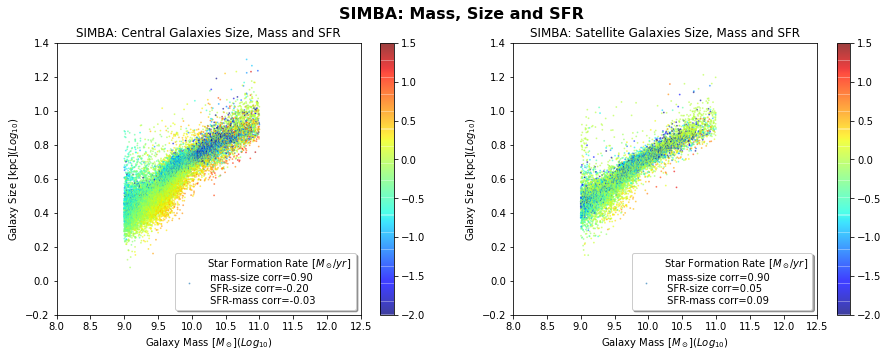

In [58]:
import matplotlib.cm as cm
import matplotlib.colors as norm

fig4,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig4.suptitle('SIMBA: Mass, Size and SFR', fontsize=16, fontweight='bold')

im1 = ax1.scatter(central_galaxies_mass, central_galaxies_size, 
                  c = (central_galaxies_SFR), cmap = plt.cm.jet, s=3, marker='.', alpha=0.5, vmin=-2, vmax=1.5,
                  label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.90 \n SFR-size corr=-0.20 \n SFR-mass corr=-0.03')
ax1.set_xlim([8.0, 12.5])
ax1.set_ylim([-0.2, 1.4])
ax1.set_title('SIMBA: Central Galaxies Size, Mass and SFR')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax1.legend(loc='lower right', shadow=True)
fig4.colorbar(im1, ax=ax1)

im2 = ax2.scatter(satellite_galaxies_mass, satellite_galaxies_size, 
                  c = (satellite_galaxies_SFR), cmap = plt.cm.jet, s=3, marker='.', alpha=0.5, vmin=-2, vmax=1.5,
                  label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.90 \n SFR-size corr=0.05 \n SFR-mass corr=0.09')
ax2.set_xlim([8.0, 12.5])
ax2.set_ylim([-0.2, 1.4])
ax2.set_title('SIMBA: Satellite Galaxies Size, Mass and SFR')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)
fig4.colorbar(im2, ax=ax2)

#plt.savefig("SIMBA_central_satellite_SFR_Mstar9to11_v2.jpeg", dpi=500)
plt.show()

### Scatter plot

fig3,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

ax1.plot(central_galaxies_mass, central_galaxies_size, '.', markersize=2)
ax1.set_title('SIMBA: Scatterplot of Size vs Mass \n for Central Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')

ax2.plot(satellite_galaxies_mass, satellite_galaxies_size, '.', markersize=2, color='g')
ax2.set_title('SIMBA: Scatterplot of Size vs Mass \n for Satellite Galaxies')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
plt.show()

#plt.savefig("TNG501_central_satellite_scatterplot.jpeg", dpi=500)

In [60]:
def plot_df_mass_size_sfr(df, galaxy_type = 'central'):
    
    sub_df = df.loc[df["galaxy_type"] == galaxy_type, ["galaxy_mass_log","galaxy_size_log", 'SFR']]
    plt.scatter(sub_df["galaxy_mass_log"], sub_df["galaxy_size_log"], c = np.log10(sub_df['SFR']+0.01), 
                s=3, marker=".", label='Star Formation Rate [$M_\odot / yr$] \n mass-size correlation=0.66')
    plt.xlabel('Total Mass [$M_\odot$]')
    plt.ylabel('Galaxy Size [kpc]($ Log_{10} $)')
    plt.legend(shadow = True)
    plt.colorbar()
    plt.show()

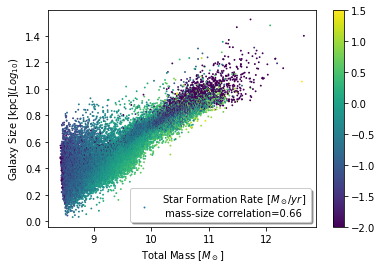

In [61]:
plot_df_mass_size_sfr(df_SIMBA_mass_filtered, galaxy_type= 'central')

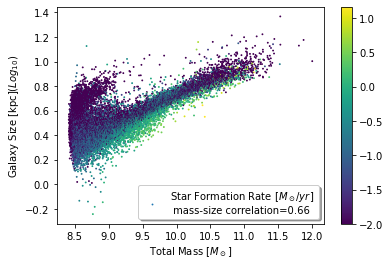

In [62]:
plot_df_mass_size_sfr(df_SIMBA_mass_filtered, galaxy_type= 'satellite')

### Size vs Mass plot

#### 1D Histograms

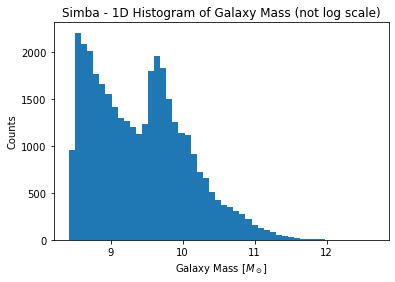

In [43]:
plt.hist(central_galaxies_mass,bins=50)
plt.title('Simba - 1D Histogram of Galaxy Mass (not log scale)')
#plt.xscale('log')
plt.ylabel('Counts')
plt.xlabel('Galaxy Mass [$ M_\odot $]')
#plt.savefig("Simba_GalaxyStellarMass_Hist1D_nonlog.jpeg", dpi=500)
plt.show()

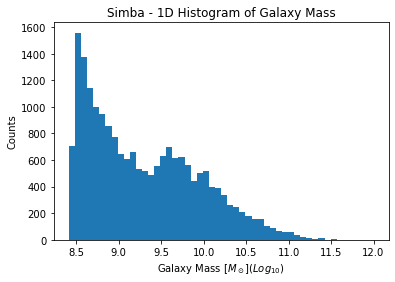

In [44]:
plt.hist(satellite_galaxies_mass,bins=50)
plt.title('Simba - 1D Histogram of Galaxy Mass')
plt.ylabel('Counts')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
#plt.savefig("Simba_GalaxyStellarMass_Hist1D.jpeg", dpi=500)
plt.show()

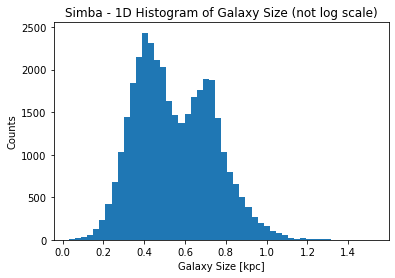

In [45]:
plt.hist(central_galaxies_size,bins=50)
plt.title('Simba - 1D Histogram of Galaxy Size (not log scale)')
plt.ylabel('Counts')
plt.xlabel('Galaxy Size [kpc]')
#plt.savefig("Simba_GalaxySize_Hist1D_nonlog.jpeg", dpi=500)
plt.show()

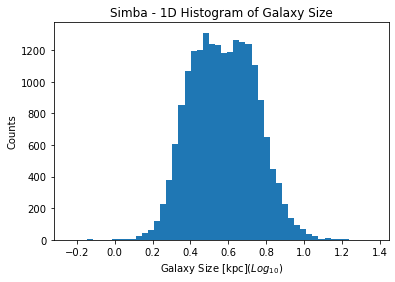

In [46]:
plt.hist(satellite_galaxies_size,bins=50)
plt.title('Simba - 1D Histogram of Galaxy Size')
plt.ylabel('Counts')
plt.xlabel('Galaxy Size [kpc]($ Log_{10} $)')
#plt.savefig("Simba_GalaxySize_Hist1D.jpeg", dpi=500)
plt.show()

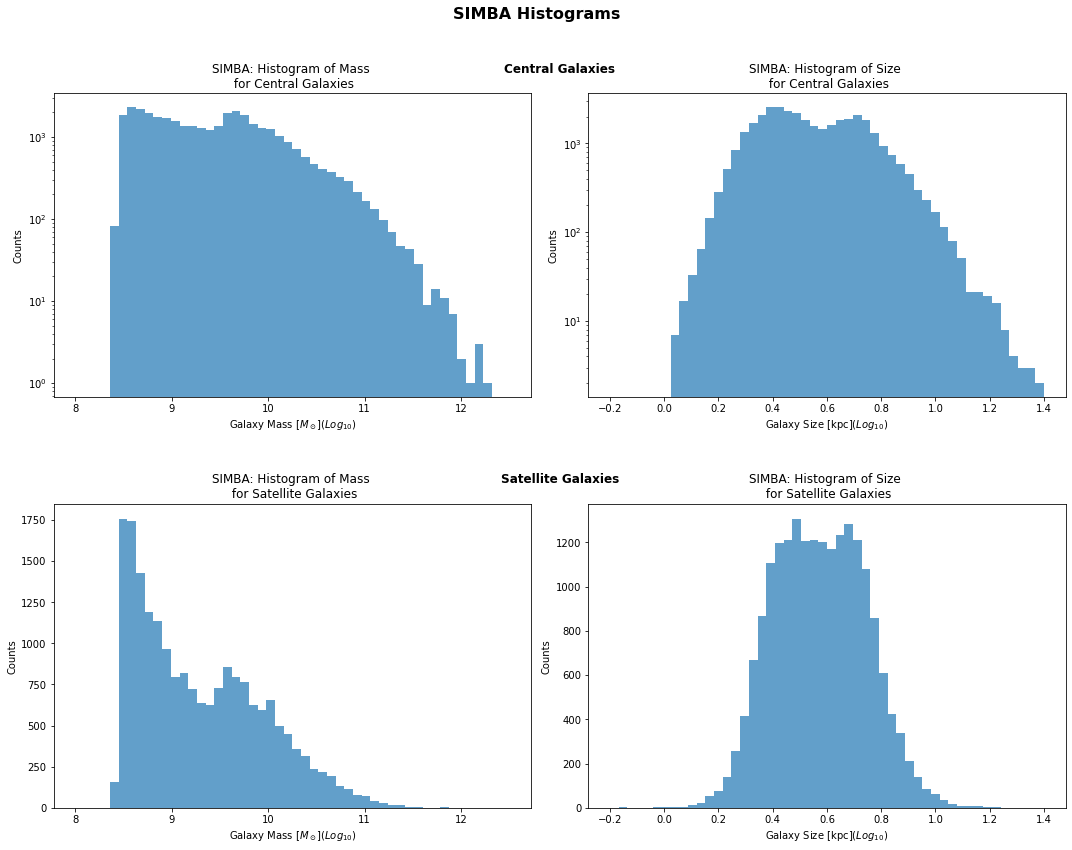

In [47]:
fig,[(ax1, ax2), (ax3, ax4)]=plt.subplots(nrows=2,ncols=2,figsize=(15,12))
fig.suptitle('SIMBA Histograms', fontsize=16, fontweight='bold')

ax1.hist(central_galaxies_mass, bins=50, log=True, alpha=0.7, range=(8.0, 12.5))
#ax1.hist(central_galaxies_mass_TNG100, bins=50, log=True, alpha=0.5, label='TNG100')
ax1.set_title('SIMBA: Histogram of Mass \n for Central Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Counts')
#ax1.legend(loc='upper right')

ax2.hist(central_galaxies_size,bins=50, log=True, alpha=0.7, range=(-0.2, 1.4))
#ax2.hist(central_galaxies_size_TNG100, bins=50, log=True, alpha=0.5, label='TNG100')
ax2.set_title('SIMBA: Histogram of Size \n for Central Galaxies')
ax2.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.set_ylabel('Counts')
#ax2.legend(loc='upper right')

ax3.hist(satellite_galaxies_mass, bins=50, alpha=0.7, range=(8.0, 12.5))
#ax3.hist(satellite_galaxies_mass_TNG100, bins=50, alpha=0.5, label='TNG100')
ax3.set_title('SIMBA: Histogram of Mass \n for Satellite Galaxies')
ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax3.set_ylabel('Counts')
#ax3.legend(loc='upper right')

ax4.hist(satellite_galaxies_size, bins=50, alpha=0.7, range=(-0.2, 1.4))
#ax4.hist(satellite_galaxies_size_TNG100, bins=50, alpha=0.5, label='TNG100')
ax4.set_title('SIMBA: Histogram of Size \n for Satellite Galaxies')
ax4.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax4.set_ylabel('Counts')
#ax4.legend(loc='upper right')

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
grid = plt.GridSpec(2, 2)
create_subtitle(fig, grid[0, ::], 'Central Galaxies')
create_subtitle(fig, grid[1, ::], 'Satellite Galaxies')
fig.tight_layout()
fig.subplots_adjust(top=0.88)
#plt.savefig("SIMBA_central_satellites_Hist1D.jpeg", dpi=500)
plt.show()

In [48]:
pwd

'/Users/festabu/Desktop/ML_galaxy_size_project/Codes/simba/caesar'

#### 2D Histogram

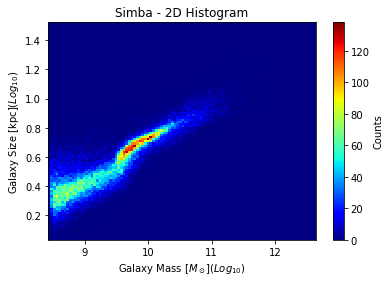

In [49]:
# Figure using the Matplotlib hist2d

plt.hist2d(central_galaxies_mass, central_galaxies_size, cmap = plt.cm.jet, bins=100)
plt.title('Simba - 2D Histogram')
plt.ylabel('Galaxy Size [kpc]($ Log_{10} $)')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
#plt.savefig("Simba_GalaxyStellarMass_vs_Size_v1.jpeg", dpi=500)
plt.show()

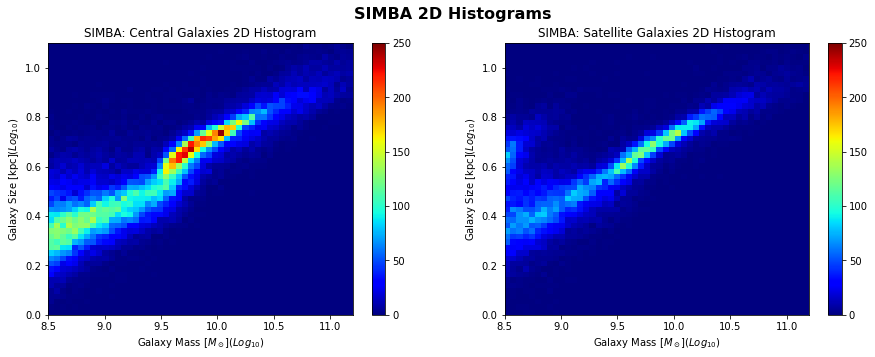

In [51]:
# Figure using the Matplotlib hist2d
fig3,[ax1, ax2] =plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig3.suptitle('SIMBA 2D Histograms', fontsize=16, fontweight='bold')

im1 = ax1.hist2d(central_galaxies_mass, central_galaxies_size, cmap = plt.cm.jet, bins=50, vmin=0, vmax=250,
                 range=[[8.5,11.2],[0.0,1.1]])
ax1.set_title('SIMBA: Central Galaxies 2D Histogram')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
fig3.colorbar(im1[3], ax=ax1)

im2 = ax2.hist2d(satellite_galaxies_mass, satellite_galaxies_size, cmap = plt.cm.jet, bins=50, vmin=0, vmax=250,
                range=[[8.5,11.2],[0.0,1.1]])
ax2.set_title('SIMBA: Satellite Galaxies 2D Histogram')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
fig3.colorbar(im2[3], ax=ax2)

# im3 = ax3.hist2d(central_galaxies_mass_TNG100, central_galaxies_size_TNG100, cmap = plt.cm.jet, bins=50, range=[[8,11.3],[-0.5,1.2]])
# ax3.set_title('TNG100-1: Central Galaxies 2D Histogram')
# ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
# ax3.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
# fig3.colorbar(im1[3], ax=ax3)

# im4 = ax4.hist2d(satellite_galaxies_mass_TNG100, satellite_galaxies_size_TNG100, cmap = plt.cm.jet, bins=50, range=[[8,10.0],[-1.2,1.0]])
# ax4.set_title('TNG100-1: Satellite Galaxies 2D Histogram')
# ax4.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
# ax4.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
# fig3.colorbar(im2[3], ax=ax4)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid3 = plt.GridSpec(2, 2)
# create_subtitle(fig3, grid3[0, ::], 'TNG50-1 Galaxies')
# create_subtitle(fig3, grid3[1, ::], 'TNG100-1 Galaxies')
# fig3.tight_layout()
# fig3.subplots_adjust(top=0.88)

#plt.savefig("SIMBA_central_satellite_Hist2D.jpeg", dpi=500)
plt.show()



## Size vs Mass, and SFR

#### <font color='blue'> Spearman correlations 

In [52]:
mass_size_corr_central = stats.spearmanr(central_galaxies_mass, central_galaxies_size )
SFR_size_corr_central = stats.spearmanr(central_galaxies_SFR, central_galaxies_size )
SFR_mass_corr_central = stats.spearmanr(central_galaxies_SFR, central_galaxies_mass )

mass_size_corr_satellite = stats.spearmanr(satellite_galaxies_mass, satellite_galaxies_size )
SFR_size_corr_satellite = stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_size )
SFR_mass_corr_satellite = stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_mass )

In [53]:
print('mass_size_corr_central_SIMBA', mass_size_corr_central)
print('SFR_size_corr_central_SIMBA', SFR_size_corr_central)
print('SFR_mass_corr_central_SIMBA', SFR_mass_corr_central)

print('mass_size_corr_satellite_SIMBA', mass_size_corr_satellite)
print('SFR_size_corr_satellite_SIMBA', SFR_size_corr_satellite)
print('SFR_mass_corr_satellite_SIMBA', SFR_mass_corr_satellite)

mass_size_corr_central_SIMBA SpearmanrResult(correlation=0.8672220737345897, pvalue=0.0)
SFR_size_corr_central_SIMBA SpearmanrResult(correlation=0.18405832421706317, pvalue=1.3464559937326064e-270)
SFR_mass_corr_central_SIMBA SpearmanrResult(correlation=0.38932136021923847, pvalue=0.0)
mass_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.6783101563976326, pvalue=0.0)
SFR_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.27980988288997266, pvalue=0.0)
SFR_mass_corr_satellite_SIMBA SpearmanrResult(correlation=0.10816751298598558, pvalue=1.6151910760174592e-52)


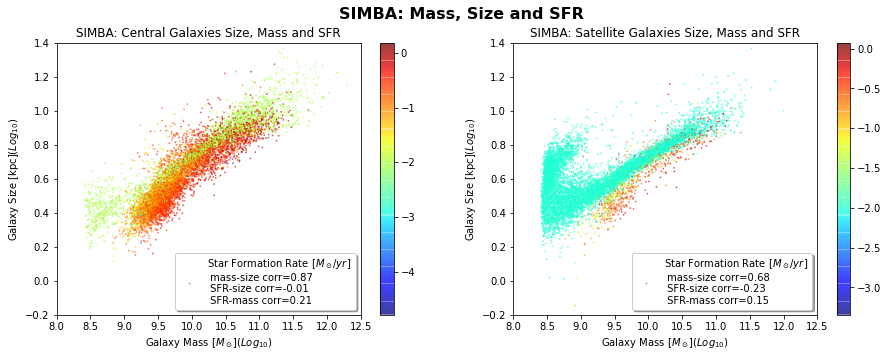

In [57]:
fig4,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig4.suptitle('SIMBA: Mass, Size and SFR', fontsize=16, fontweight='bold')

im1 = ax1.scatter(central_galaxies_mass, central_galaxies_size, 
                  c = np.log10(central_galaxies_SFR + 0.01), cmap = plt.cm.jet, s=3, marker='.', alpha=0.5,
                  label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.87 \n SFR-size corr=-0.01 \n SFR-mass corr=0.21')
ax1.set_xlim([8.0, 12.5])
ax1.set_ylim([-0.2, 1.4])
ax1.set_title('SIMBA: Central Galaxies Size, Mass and SFR')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax1.legend(loc='lower right', shadow=True)
fig4.colorbar(im1, ax=ax1)

im2 = ax2.scatter(satellite_galaxies_mass, satellite_galaxies_size, 
                  c = np.log10(satellite_galaxies_SFR + 0.01), cmap = plt.cm.jet, s=3, marker='.', alpha=0.5,
                  label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.68 \n SFR-size corr=-0.23 \n SFR-mass corr=0.15')
ax2.set_xlim([8.0, 12.5])
ax2.set_ylim([-0.2, 1.4])
ax2.set_title('SIMBA: Satellite Galaxies Size, Mass and SFR')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)
fig4.colorbar(im2, ax=ax2)

# im3 = ax3.scatter(central_galaxies_mass_TNG100, central_galaxies_size_TNG100, 
#                   c = np.log10(central_galaxies_SFR_TNG100 + 0.01), cmap = plt.cm.jet, s=30, marker='o', 
#                   label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.23 \n SFR-size corr=0.01 \n SFR-mass corr=0.45')
# ax3.set_title('TNG100-1: Central Galaxies Size, Mass and SFR')
# ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
# ax3.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
# ax3.legend( loc='lower right', shadow=True)
# fig4.colorbar(im3, ax=ax3)

# im4 = ax4.scatter(satellite_galaxies_mass_TNG100, satellite_galaxies_size_TNG100, 
#                   c = np.log10(satellite_galaxies_SFR_TNG100 + 0.01), cmap = plt.cm.jet, s=30, marker='o', 
#                   label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=-0.72 \n SFR-size corr=0.25 \n SFR-mass corr=0.08')
# ax4.set_title('TNG100-1: Satellite Galaxies Size, Mass and SFR')
# ax4.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
# ax4.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
# ax4.legend(loc='lower right', shadow=True)
# fig4.colorbar(im4, ax=ax4)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid4 = plt.GridSpec(2, 2)
# create_subtitle(fig4, grid4[0, ::], 'TNG50-1 Galaxies')
# create_subtitle(fig4, grid4[1, ::], 'TNG100-1 Galaxies')
# fig4.tight_layout()
# fig4.subplots_adjust(top=0.88)

#plt.savefig("SIMBA_central_satellite_SFR.jpeg", dpi=500)
plt.show()

## Size vs Mass, and Hydrogen

#### <font color='blue'> Spearman correlations 

In [58]:
mass_size_corr_central = stats.spearmanr(central_galaxies_mass, central_galaxies_size )
mHI_size_corr_central = stats.spearmanr(central_galaxies_mHI, central_galaxies_size )
mHI_mass_corr_central = stats.spearmanr(central_galaxies_mHI, central_galaxies_mass )
SFR_mHI_corr_central = stats.spearmanr(central_galaxies_SFR, central_galaxies_mHI )


mass_size_corr_satellite = stats.spearmanr(satellite_galaxies_mass, satellite_galaxies_size )
mHI_size_corr_satellite = stats.spearmanr(satellite_galaxies_mHI, satellite_galaxies_size )
mHI_mass_corr_satellite = stats.spearmanr(satellite_galaxies_mHI, satellite_galaxies_mass )
SFR_mHI_corr_satellite = stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_mHI )

In [59]:
print('mass_size_corr_central_SIMBA', mass_size_corr_central)
print('mHI_size_corr_central_SIMBA', mHI_size_corr_central)
print('mHI_mass_corr_central_SIMBA', mHI_mass_corr_central)
print('SFR_mHI_corr_central_SIMBA', SFR_mHI_corr_central)

print('mass_size_corr_satellite_SIMBA', mass_size_corr_satellite)
print('mHI_size_corr_satellite_SIMBA', mHI_size_corr_satellite)
print('mHI_mass_corr_satellite_SIMBA', mHI_mass_corr_satellite)
print('SFR_mHI_corr_satellite_SIMBA', SFR_mHI_corr_satellite)

mass_size_corr_central_SIMBA SpearmanrResult(correlation=0.8672220737345897, pvalue=0.0)
mHI_size_corr_central_SIMBA SpearmanrResult(correlation=0.21399510734245958, pvalue=0.0)
mHI_mass_corr_central_SIMBA SpearmanrResult(correlation=0.2135738279416467, pvalue=0.0)
SFR_mHI_corr_central_SIMBA SpearmanrResult(correlation=0.4168432793692458, pvalue=0.0)
mass_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.6783101563976326, pvalue=0.0)
mHI_size_corr_satellite_SIMBA SpearmanrResult(correlation=-0.0940816398141908, pvalue=4.18412314869338e-40)
mHI_mass_corr_satellite_SIMBA SpearmanrResult(correlation=0.30725649972724534, pvalue=0.0)
SFR_mHI_corr_satellite_SIMBA SpearmanrResult(correlation=-0.44431975954560265, pvalue=0.0)


In [60]:
mass_size_corr_central = stats.spearmanr(central_galaxies_mass, central_galaxies_size )
mH2_size_corr_central = stats.spearmanr(central_galaxies_mH2, central_galaxies_size )
mH2_mass_corr_central = stats.spearmanr(central_galaxies_mH2, central_galaxies_mass )
SFR_mH2_corr_central = stats.spearmanr(central_galaxies_SFR, central_galaxies_mH2 )

mass_size_corr_satellite = stats.spearmanr(satellite_galaxies_mass, satellite_galaxies_size )
mH2_size_corr_satellite = stats.spearmanr(satellite_galaxies_mH2, satellite_galaxies_size )
mH2_mass_corr_satellite = stats.spearmanr(satellite_galaxies_mH2, satellite_galaxies_mass )
SFR_mH2_corr_satellite = stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_mH2 )

In [61]:
print('mass_size_corr_central_SIMBA', mass_size_corr_central)
print('mH2_size_corr_central_SIMBA', mH2_size_corr_central)
print('mH2_mass_corr_central_SIMBA', mH2_mass_corr_central)
print('SFR_mH2_corr_central_SIMBA', SFR_mH2_corr_central)

print('mass_size_corr_satellite_SIMBA', mass_size_corr_satellite)
print('mH2_size_corr_satellite_SIMBA', mH2_size_corr_satellite)
print('mH2_mass_corr_satellite_SIMBA', mH2_mass_corr_satellite)
print('SFR_mH2_corr_satellite_SIMBA', SFR_mH2_corr_satellite)

mass_size_corr_central_SIMBA SpearmanrResult(correlation=0.8672220737345897, pvalue=0.0)
mH2_size_corr_central_SIMBA SpearmanrResult(correlation=0.2502467894282382, pvalue=0.0)
mH2_mass_corr_central_SIMBA SpearmanrResult(correlation=0.40901990982635444, pvalue=0.0)
SFR_mH2_corr_central_SIMBA SpearmanrResult(correlation=0.6676455038493244, pvalue=0.0)
mass_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.6783101563976326, pvalue=0.0)
mH2_size_corr_satellite_SIMBA SpearmanrResult(correlation=-0.12909920897071636, pvalue=3.243212089070952e-74)
mH2_mass_corr_satellite_SIMBA SpearmanrResult(correlation=0.2375363543004763, pvalue=1.3343595695545986e-251)
SFR_mH2_corr_satellite_SIMBA SpearmanrResult(correlation=-0.435609908516866, pvalue=0.0)


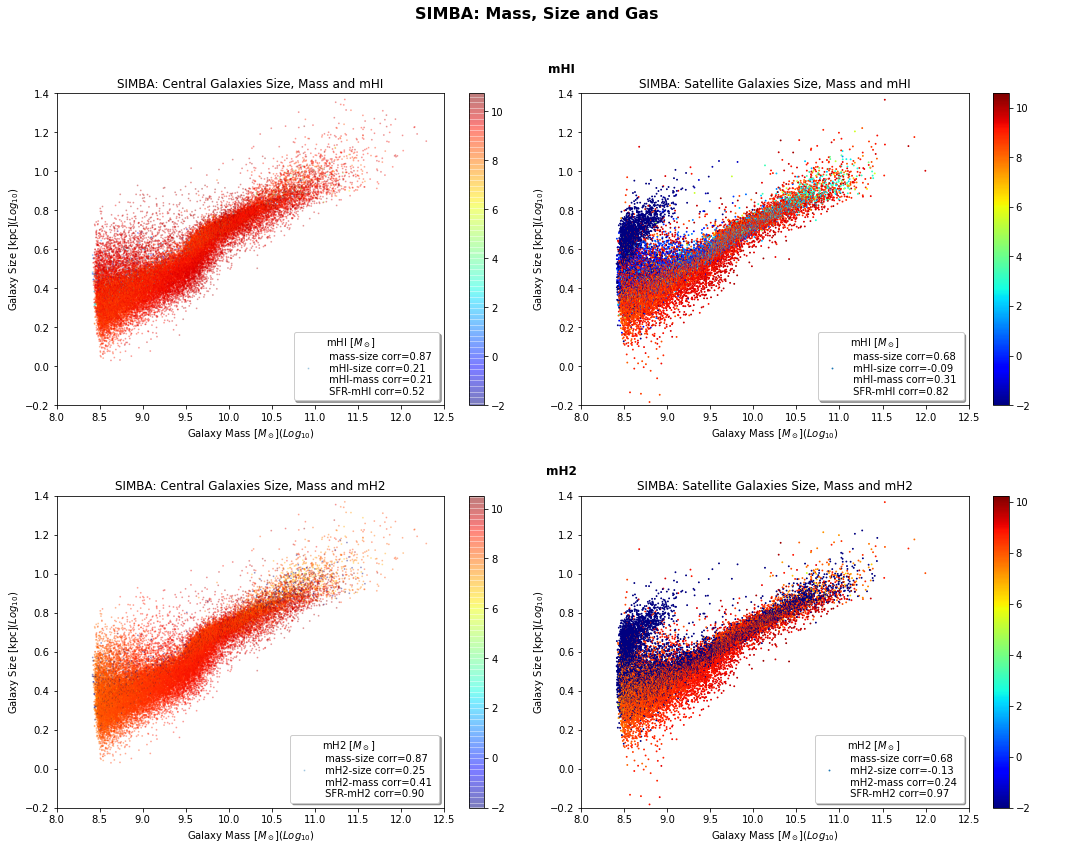

In [63]:
import matplotlib.cm as cm
import matplotlib.colors as norm

fig2,[(ax1, ax2), (ax3, ax4)]=plt.subplots(nrows=2,ncols=2,figsize=(15,12))
fig2.suptitle('SIMBA: Mass, Size and Gas', fontsize=16, fontweight='bold')

im1 = ax1.scatter(central_galaxies_mass, central_galaxies_size, 
                  c = np.log10(central_galaxies_mHI + 0.01), cmap = plt.cm.jet, s=3, marker='.', alpha=0.3,
                  label='mHI [$M_\odot $] \n mass-size corr=0.87 \n mHI-size corr=0.21 \n mHI-mass corr=0.21 \n SFR-mHI corr=0.52')
ax1.set_xlim([8.0, 12.5])
ax1.set_ylim([-0.2, 1.4])
ax1.set_title('SIMBA: Central Galaxies Size, Mass and mHI')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax1.legend(loc='lower right', shadow=True)
fig2.colorbar(im1, ax=ax1)

im2 = ax2.scatter(satellite_galaxies_mass, satellite_galaxies_size, 
                  c = np.log10(satellite_galaxies_mHI + 0.01), cmap = plt.cm.jet, s=3, marker='.', 
                  label='mHI [$M_\odot $] \n mass-size corr=0.68 \n mHI-size corr=-0.09 \n mHI-mass corr=0.31 \n SFR-mHI corr=0.82')
ax2.set_xlim([8.0, 12.5])
ax2.set_ylim([-0.2, 1.4])
ax2.set_title('SIMBA: Satellite Galaxies Size, Mass and mHI')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)
fig2.colorbar(im2, ax=ax2)

im3 = ax3.scatter(central_galaxies_mass, central_galaxies_size, 
                  c = np.log10(central_galaxies_mH2 + 0.01), cmap = plt.cm.jet, s=3, marker='.', alpha=0.3,
                  label='mH2 [$M_\odot $] \n mass-size corr=0.87 \n mH2-size corr=0.25 \n mH2-mass corr=0.41 \n SFR-mH2 corr=0.90')
ax3.set_xlim([8.0, 12.5])
ax3.set_ylim([-0.2, 1.4])
ax3.set_title('SIMBA: Central Galaxies Size, Mass and mH2')
ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax3.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax3.legend( loc='lower right', shadow=True)
fig2.colorbar(im3, ax=ax3)

im4 = ax4.scatter(satellite_galaxies_mass, satellite_galaxies_size, 
                  c = np.log10(satellite_galaxies_mH2 + 0.01), cmap = plt.cm.jet, s=3, marker='.', 
                  label='mH2 [$M_\odot $] \n mass-size corr=0.68 \n mH2-size corr=-0.13 \n mH2-mass corr=0.24 \n SFR-mH2 corr=0.97')
ax4.set_xlim([8.0, 12.5])
ax4.set_ylim([-0.2, 1.4])
ax4.set_title('SIMBA: Satellite Galaxies Size, Mass and mH2')
ax4.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax4.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax4.legend(loc='lower right', shadow=True)
fig2.colorbar(im4, ax=ax4)

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
grid2 = plt.GridSpec(2, 2)
create_subtitle(fig2, grid2[0, ::], 'mHI')
create_subtitle(fig2, grid2[1, ::], 'mH2')
fig2.tight_layout()
fig2.subplots_adjust(top=0.88)

#plt.savefig("SIMBA_central_satellite_Gas.jpeg", dpi=500)
plt.show()

## Size vs Mass, and Halo Mass

#### <font color='blue'> Spearman correlations 

In [64]:
mass_size_corr_central = stats.spearmanr(central_galaxies_mass, central_galaxies_size )
Mhalo_size_corr_central = stats.spearmanr(central_galaxies_Mhalo, central_galaxies_size )
Mhalo_mass_corr_central = stats.spearmanr(central_galaxies_Mhalo, central_galaxies_mass )
SFR_Mhalo_corr_central = stats.spearmanr(central_galaxies_SFR, central_galaxies_Mhalo )


mass_size_corr_satellite = stats.spearmanr(satellite_galaxies_mass, satellite_galaxies_size )
Mhalo_size_corr_satellite = stats.spearmanr(satellite_galaxies_Mhalo, satellite_galaxies_size )
Mhalo_mass_corr_satellite = stats.spearmanr(satellite_galaxies_Mhalo, satellite_galaxies_mass )
SFR_Mhalo_corr_satellite = stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_Mhalo )

In [65]:
print('mass_size_corr_central_SIMBA', mass_size_corr_central)
print('Mhalo_size_corr_central_SIMBA', Mhalo_size_corr_central)
print('Mhalo_mass_corr_central_SIMBA', Mhalo_mass_corr_central)
print('SFR_Mhalo_corr_central_SIMBA', SFR_Mhalo_corr_central)

print('mass_size_corr_satellite_SIMBA', mass_size_corr_satellite)
print('Mhalo_size_corr_satellite_SIMBA', Mhalo_size_corr_satellite)
print('Mhalo_mass_corr_satellite_SIMBA', Mhalo_mass_corr_satellite)
print('SFR_Mhalo_corr_satellite_SIMBA', SFR_Mhalo_corr_satellite)

mass_size_corr_central_SIMBA SpearmanrResult(correlation=0.8672220737345897, pvalue=0.0)
Mhalo_size_corr_central_SIMBA SpearmanrResult(correlation=0.8305706767042852, pvalue=0.0)
Mhalo_mass_corr_central_SIMBA SpearmanrResult(correlation=0.8803034667681129, pvalue=0.0)
SFR_Mhalo_corr_central_SIMBA SpearmanrResult(correlation=0.34604970957770986, pvalue=0.0)
mass_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.6783101563976326, pvalue=0.0)
Mhalo_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.3551272058569932, pvalue=0.0)
Mhalo_mass_corr_satellite_SIMBA SpearmanrResult(correlation=0.09415799943283538, pvalue=3.622565161371603e-40)
SFR_Mhalo_corr_satellite_SIMBA SpearmanrResult(correlation=0.40211445041173466, pvalue=0.0)


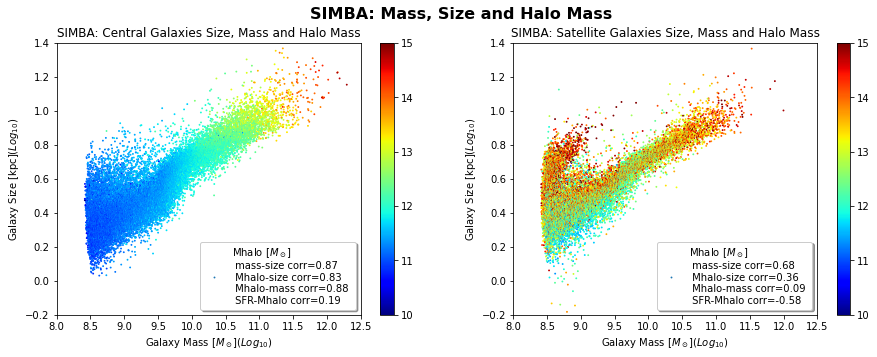

In [67]:
fig5,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig5.suptitle('SIMBA: Mass, Size and Halo Mass', fontsize=16, fontweight='bold')

im1 = ax1.scatter(central_galaxies_mass, central_galaxies_size, 
                  c = np.log10(central_galaxies_Mhalo), cmap = plt.cm.jet, s=3, marker='.', vmin=10, vmax=15,
                  label='Mhalo [$M_\odot $] \n mass-size corr=0.87 \n Mhalo-size corr=0.83 \n Mhalo-mass corr=0.88 \n SFR-Mhalo corr=0.19')
ax1.set_xlim([8.0, 12.5])
ax1.set_ylim([-0.2, 1.4])
ax1.set_title('SIMBA: Central Galaxies Size, Mass and Halo Mass')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax1.legend(loc='lower right', shadow=True)
fig5.colorbar(im1, ax=ax1)

im2 = ax2.scatter(satellite_galaxies_mass, satellite_galaxies_size, 
                  c = np.log10(satellite_galaxies_Mhalo), cmap = plt.cm.jet, s=3, marker='.', vmin=10, vmax=15,
                  label='Mhalo [$M_\odot $] \n mass-size corr=0.68 \n Mhalo-size corr=0.36 \n Mhalo-mass corr=0.09 \n SFR-Mhalo corr=-0.58')
ax2.set_xlim([8.0, 12.5])
ax2.set_ylim([-0.2, 1.4])
ax2.set_title('SIMBA: Satellite Galaxies Size, Mass and Halo Mass')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)
fig5.colorbar(im2, ax=ax2)


#plt.savefig("SIMBA_central_satellite_Halomass.jpeg", dpi=500)
plt.show()

In [68]:
np.log10(min(satellite_galaxies_Mhalo))

10.913933643853658

In [69]:
np.log10(min(central_galaxies_Mhalo)) # how come the minimum of centrals is smaller than that of satellites?

9.951475103255413

In [70]:
np.log10(max(satellite_galaxies_Mhalo))

15.025342958528013

In [72]:
np.log10(max(central_galaxies_Mhalo)) # satellites and centrals have the same max Mhalo

15.025342958528013

## Size vs Mass, and Halo Spin

#### <font color='blue'> Spearman correlations 

In [73]:
np.count_nonzero(central_galaxies_Shalo)

35822

In [74]:
central_galaxies_Shalo

0             inf
1        0.002251
2        0.002041
3             inf
4        0.003263
           ...   
55586    0.003349
55588    0.011734
55597    0.046609
55601    1.302301
55602    0.354070
Name: Shalo, Length: 35843, dtype: float64

In [75]:
df_SIMBA_mass_filtered['Shalo'].value_counts()

inf         807
0.003573    293
0.002041    248
0.004138    199
0.002350    155
           ... 
0.013356      1
0.013605      1
0.001721      1
0.014495      1
0.001810      1
Name: Shalo, Length: 35822, dtype: int64

In [76]:
mass_size_corr_central = stats.spearmanr(central_galaxies_mass, central_galaxies_size )
Shalo_size_corr_central = stats.spearmanr(central_galaxies_Shalo, central_galaxies_size )
Shalo_mass_corr_central = stats.spearmanr(central_galaxies_Shalo, central_galaxies_mass )
SFR_Shalo_corr_central = stats.spearmanr(central_galaxies_SFR, central_galaxies_Shalo )


mass_size_corr_satellite = stats.spearmanr(satellite_galaxies_mass, satellite_galaxies_size )
Shalo_size_corr_satellite = stats.spearmanr(satellite_galaxies_Shalo, satellite_galaxies_size )
Shalo_mass_corr_satellite = stats.spearmanr(satellite_galaxies_Shalo, satellite_galaxies_mass )
SFR_Shalo_corr_satellite = stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_Shalo )

In [77]:
print('mass_size_corr_central_SIMBA', mass_size_corr_central)
print('Shalo_size_corr_central_SIMBA', Shalo_size_corr_central)
print('Shalo_mass_corr_central_SIMBA', Shalo_mass_corr_central)
print('SFR_Shalo_corr_central_SIMBA', SFR_Shalo_corr_central)

print('mass_size_corr_satellite_SIMBA', mass_size_corr_satellite)
print('Shalo_size_corr_satellite_SIMBA', Shalo_size_corr_satellite)
print('Shalo_mass_corr_satellite_SIMBA', Shalo_mass_corr_satellite)
print('SFR_Shalo_corr_satellite_SIMBA', SFR_Shalo_corr_satellite)

mass_size_corr_central_SIMBA SpearmanrResult(correlation=0.8672220737345897, pvalue=0.0)
Shalo_size_corr_central_SIMBA SpearmanrResult(correlation=-0.11529528863098794, pvalue=2.5811658615306756e-106)
Shalo_mass_corr_central_SIMBA SpearmanrResult(correlation=-0.1039415422889897, pvalue=1.1626845877761725e-86)
SFR_Shalo_corr_central_SIMBA SpearmanrResult(correlation=0.14481032901878504, pvalue=3.3331157161423165e-167)
mass_size_corr_satellite_SIMBA SpearmanrResult(correlation=0.6783101563976326, pvalue=0.0)
Shalo_size_corr_satellite_SIMBA SpearmanrResult(correlation=-0.08680540155007313, pvalue=2.24616117395552e-34)
Shalo_mass_corr_satellite_SIMBA SpearmanrResult(correlation=0.010103979504897652, pvalue=0.15546765670499677)
SFR_Shalo_corr_satellite_SIMBA SpearmanrResult(correlation=-0.039596523319791216, pvalue=2.5654298334577814e-08)


In [80]:
np.count_nonzero(central_galaxies_Shalo)

35822

In [81]:
np.count_nonzero(satellite_galaxies_Shalo)

19766

In [82]:
19766+19766

39532

In [83]:
39532+807

40339

In [86]:
min(central_galaxies_Shalo)

0.0

In [87]:
max(central_galaxies_Shalo)

inf

In [88]:
min(satellite_galaxies_Shalo)

3.105768487468107e-05

In [90]:
max(satellite_galaxies_Shalo)

inf

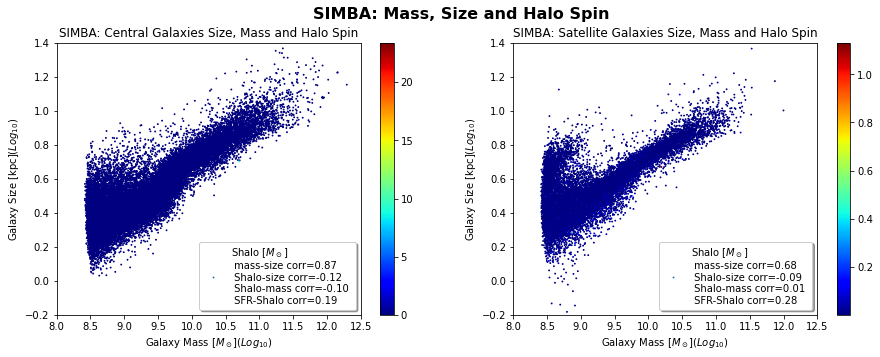

In [85]:
fig6,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig6.suptitle('SIMBA: Mass, Size and Halo Spin', fontsize=16, fontweight='bold')

im1 = ax1.scatter(central_galaxies_mass, central_galaxies_size, 
                  c = central_galaxies_Shalo , cmap = plt.cm.jet, s=3, marker='.', 
                  label='Shalo [$M_\odot $] \n mass-size corr=0.87 \n Shalo-size corr=-0.12 \n Shalo-mass corr=-0.10 \n SFR-Shalo corr=0.19')
ax1.set_xlim([8.0, 12.5])
ax1.set_ylim([-0.2, 1.4])
ax1.set_title('SIMBA: Central Galaxies Size, Mass and Halo Spin')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax1.legend(loc='lower right', shadow=True)
fig6.colorbar(im1, ax=ax1)

im2 = ax2.scatter(satellite_galaxies_mass, satellite_galaxies_size, 
                  c = satellite_galaxies_Shalo , cmap = plt.cm.jet, s=3, marker='.', 
                  label='Shalo [$M_\odot $] \n mass-size corr=0.68 \n Shalo-size corr=-0.09 \n Shalo-mass corr=0.01 \n SFR-Shalo corr=0.28')
ax2.set_xlim([8.0, 12.5])
ax2.set_ylim([-0.2, 1.4])
ax2.set_title('SIMBA: Satellite Galaxies Size, Mass and Halo Spin')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)
fig6.colorbar(im2, ax=ax2)


#plt.savefig("SIMBA_central_satellite_Halospin.jpeg", dpi=500)
plt.show()

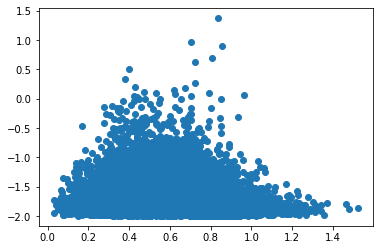

In [68]:
plt.scatter(central_galaxies_size, np.log10(central_galaxies_Shalo + 0.01))
plt.show()